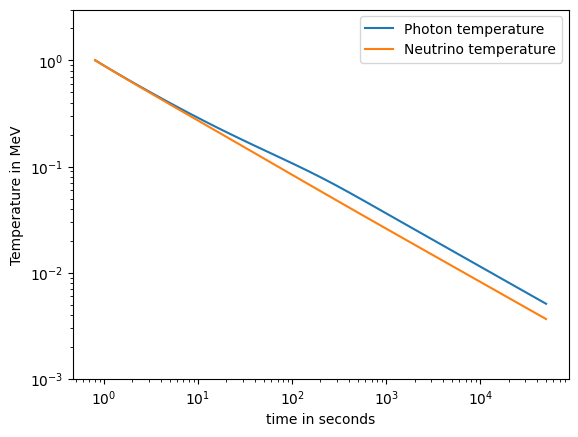

In [35]:
#Background

import scipy.constants as con
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar

import matplotlib.pyplot as plt


#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=613.9*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931                 #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11   #conversion factor for cm^3/s
barn=389.4          #conversion factor for barn
T_ini=1             #initial temperature in MeV
e_mass=0.51099895   #electron mass in MeV
z_ini=e_mass/T_ini

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta*n_gamma_ini  #initial h

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV

rho_b_ini=h_ini*T_ini**3     #initial baryon density, currently set to 0

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(T,h,a):
    return h_ini*T_ini**3/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,h,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)+rho_b(T,h,a)

def rho_set(T,h,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(T,h,a)

def H(T,h,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,h,a))



#Derivative from Kavano D.18
def dTdt(t,T,h,a):
    return -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h,a) + P_e(T)+P_gamma(T)))




dTdt(1,T_ini,h_ini,1)*timeunit

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,h,a):
    return a*H(T,h,a)


t_range=[t_ini,5e4*timeunit]            #time range for integration
t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dhdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,h_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[2], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure




In [36]:
#test background temperature
sol.y[0][-1]/(T_ini/sol.y[2][-1])
sol.y[0]/(T_ini/sol.y[2])
#nsten=20
#print(sol.y[0][nsten])
#print(sol.y[0][nsten]/(T_ini/sol.y[2][nsten]))

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.00000002, 1.00000015, 1.00000151, 1.00001512, 1.00015115,
       1.00150508, 1.00422595, 1.0078273 , 1.01237803, 1.018628  ,
       1.02696702, 1.03716929, 1.05069314, 1.0679359 , 1.08799803,
       1.11311471, 1.1430446 , 1.17535072, 1.21237816, 1.25199352,
       1.28935214, 1.3250219 , 1.35450046, 1.37394292, 1.38532347,
       1.39022213, 1.39171742, 1.39204927, 1.39210288, 1.39210406,
       1.39204493, 1.39202775, 1.39202021, 1.39195812, 1.39193966,
       1.39193136, 1.39186545, 1.39184492, 1.39183535, 1.39176311,
       1.39176175])

In [72]:
from memorize import memorize
#Reaction rates
nNucs=6
Y_ini=np.zeros(nNucs)
#Y_ini=np.array([1e-20 for i in range(nNucs)])

Xn_ini = 1/(np.exp(Q/T_ini)+1)

Y_ini[0] = 1 - Xn_ini    #Set initial proton mass fraction
Y_ini[1] = Xn_ini        #Set initial neutron mass fraction

#mass of various nuclei converted to MeV
m_n  =  1.0086649159  *M_u
m_p  =  1.00782503190 *M_u
m_d  =  2.01410177784 *M_u
m_t  =  3.01604928132 *M_u
m_He3 = 3.01602932197 *M_u
m_He4 = 4.00260325413 *M_u


@memorize()
def lambda_n2p(T):  #analytic approximation of the neutron to proton reaction rate, 
                    #as a function of photon temperature.
    z=e_mass/T
    return 1/n_life*(1 + 0.565/z - 6.382/z**2 + 11.108/z**3 + 36.492/z**4 + 27.512/z**5)

@memorize()    
def lambda_p2n(T):  #analytic approximation of the proton to neutron reaction rate, 
                    #as a function of photon temperature
    z=e_mass/T
    return 1/n_life*(5.252/z - 16.229/z**2 + 18.059/z**3 + 34.181/z**4 + 27.617/z**5)*np.exp(-Q/T)

@memorize()
def G_np(T,a):

    N=eta*n_gamma_ini/a**3 #number density
    return 4/3*(m_n*m_p*T/(2*np.pi*m_d))**1.5/N*np.exp((m_d-m_n-m_p)/T)

@memorize()
def G_nHe3(T):
    return 9/4*(m_d**2/(m_He3*m_n))**1.5*np.exp((m_n+m_He3-2*m_d)/T)

@memorize()
def G_tp(T):
    return 9/4*(m_d**2/(m_t*m_p))**1.5*np.exp((m_p+m_t-2*m_d)/T)  

@memorize()
def G_tp_nHe3(T):
    return ((m_He3*m_n)/(m_t*m_p))**1.5*np.exp((m_p+m_t-(m_n+m_He3))/T)

@memorize()
def G_nHe4(T):
    return 3*((m_d+m_t)/(m_He4*m_n))**1.5*np.exp((m_He4+m_n-m_d-m_t)/T)  

#cross sections in wack units
sv_n3=8.3*10**-16/cm3s
sv_np=4.55*10**-20/cm3s

S_dd=0.34/barn
A_dd=4.62/np.sqrt(10)

S_dt=77.5/barn
A_dt=4.97/np.sqrt(10)


'''
@memorize()
def s_d(E_d,S,A):
    return S/E_d*np.exp(-A/np.sqrt(E_d))

@memorize()
def R_dd(T):
    func=lambda v: s_d(m_d/2*v**2,S_dd,A_dd)*v\
    *(m_d/(2*np.pi*T))**1.5*4*np.pi*v**2*np.exp(-(m_d*v**2)/(2*T))
    
    result, error = integrate.quad(func, 0.001, 0.1)#[0]
    return result

@memorize()
def R_dt(T):
    func=lambda v: s_d(m_d/2*v**2,S_dt,A_dt)*v\
    *(m_d/(2*np.pi*T))**1.5*4*np.pi*v**2*np.exp(-(m_d*v**2)/(2*T))
    
    result, error = integrate.quad(func, 0.001, 0.1)#[0]
    return result
'''
@memorize()
def R_dd(T):
    func=lambda v: S_dd/(m_d/2)*(m_d/(2*np.pi*T))**1.5*4*np.pi\
    *v*np.exp(-(m_d*v**2)/(2*T)-A_dd*np.sqrt(2/m_d)/v)
    
    result, error = integrate.quad(func, 0.001, 0.1)#[0]
    return result

@memorize()
def R_dt(T):
    func=lambda v: S_dt/(m_d/2)*(m_d/(2*np.pi*T))**1.5*4*np.pi\
    *v*np.exp(-(m_d*v**2)/(2*T)-A_dt*np.sqrt(2/m_d)/v)

    result, error = integrate.quad(func, 0.001, 0.1)#[0]
    return result


#making the rates an array of functions
rates=np.array([[lambda i: 0 for i in range(nNucs)] for j in range(nNucs)])

rates[0][1]=lambda_p2n
rates[1][0]=lambda_n2p

#making the rates a temperature dependant array
def frates(T):
    
    rate=np.zeros([nNucs,nNucs])
    rate[0][1]=lambda_p2n(T)
    rate[1][0]=lambda_n2p(T)

    return rate



In [73]:
#Solving abundances

n_bparams=3
        # enumeration for different isotopes
        #  0   1   2    3    4    5
Y_labels=['p','n','d','He3','t','He4']

debugvar=['eu','agh']

def dYdt(t,Y,T,a):
    #print(Y)
    #Y = [max(1e-40, num) for num in Y]
    global debugvar
    #print('beginning:', t, T, a, Y)
    #for element in [t,T,a]+list(Y):
    #    if element != element or element == float('inf') or element == float('-inf') or element == float('nan'):
            #print([t,T,a]+list(Y))
    #        print('inputfejl')
    #        print(debugvar[0])
    #        print(debugvar[1])
    #        #print([t,T,a,Y,DYdt])
    #        break

    N=eta*n_gamma_ini/a**3 #number density
    DYdt=np.zeros(nNucs)


    #Reaction rates
    R_ddT=R_dd(T)

    #reactions
    n_p     = lambda_n2p(T)
    p_n     = lambda_p2n(T)
    pn_d    = sv_np*N*(Y[0]*Y[1] - G_np(T,a)*Y[2])
    dd_nHe3 = R_ddT*N*(Y[2]**2 - G_nHe3(T)*Y[1]*Y[3])
    dd_tp   = R_ddT*N*(Y[2]**2 - G_tp(T)*Y[4]*Y[0])
    He3n_tp = sv_n3*N*(Y[1]*Y[3] - G_tp_nHe3(T)*Y[4]*Y[0])
    td_He4n = R_dt(T)*N*(Y[2]*Y[4]-G_nHe4(T)*Y[5]*Y[1])


    DYdt[0] = Y[1]*n_p - Y[0]*p_n\
            - pn_d\
            + dd_tp/2\
            + He3n_tp  
    
    DYdt[1] = Y[0]*p_n - Y[1]*n_p\
            - pn_d\
            + dd_nHe3/2\
            - He3n_tp\
            + td_He4n

    DYdt[2] = pn_d\
            - dd_nHe3\
            - dd_tp\
            - td_He4n
    
    DYdt[3] = dd_nHe3/2\
            - He3n_tp
    
    DYdt[4] = dd_tp/2\
            + He3n_tp\
            - td_He4n
        
    DYdt[5] = td_He4n
        
    #print(' '+str([T,a,Y,DYdt]))
    #for element in DYdt:
    #    if element != element or element == float('inf') or element == float('-inf') or element == float('nan'):
            #print([t,T,a])
            #print(Y)
            #print(DYdt)
            #print(debugvar[0])
            #print(debugvar[1])
    #        print('beginning '+str([T,a,Y,DYdt]))
    #        break

    #debugvar=[[debugvar[1]],[T,a,Y,DYdt]]
        #[dydt>0 for dydt in DYdt]
    return DYdt#[DYdt[i] if Y[i]+DYdt[i]>0 else 0 for i in range(nNucs)]


def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dhdt(t,*y),dadt(t,*y)]


def dall(t,y):   #solve h and T, y[0] = T and y[1] = h
    return [dTdt(t,*y[:n_bparams]),dhdt(t,*y[:n_bparams]),dadt(t,*y[:n_bparams])]+list(dYdt(t,y[n_bparams:],y[0],y[2]))

#solY = integrate.solve_ivp(dall, [t_range[0]*0.9999, t_range[0]], [T_ini,h_ini,1]+list(Y_ini),method='RK45')#,t_eval=t_space)
#print(solY)
#solY = integrate.solve_ivp(dall, t_range, solYini.y[:,-1],method='Radau')#,t_eval=t_space)
solY = integrate.solve_ivp(dall, t_range, [T_ini,h_ini,1]+list(Y_ini),method='Radau',atol=1e-15,rtol=1e-4)#,t_eval=t_space)
#solY = integrate.Radau(dall, t_range[0], [T_ini,h_ini,1]+list(Y_ini),t_range[1])

abun=[abun[-1] for abun in solY.y[n_bparams:]]
print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ',abun[0]+abun[1]+2*abun[2]+3*abun[3]+3*abun[4]+4*abun[5])

[0.8375776541496335, 2.4748203804512814e-10, 0.00029828057611361016, 6.679651919935276e-05, 2.229241218324194e-06, 0.16205503926632603]
sum:  0.9999999999999728


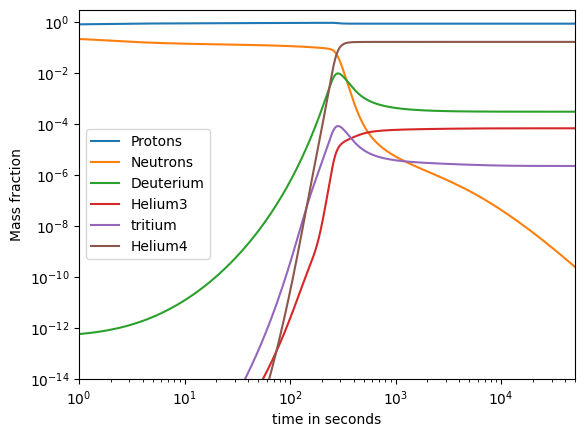

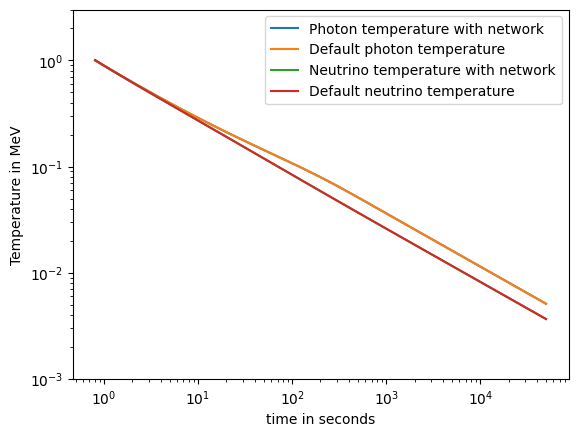

In [74]:
# Plot the results
plt.figure('abundance')
plt.plot(solY.t/timeunit, solY.y[n_bparams], label='Protons')
plt.plot(solY.t/timeunit, solY.y[n_bparams+1], label='Neutrons')
#plt.plot(solY.t/timeunit, -solY.y[n_bparams+1], label='-Neutrons')
plt.plot(solY.t/timeunit, 2*solY.y[n_bparams+2], label='Deuterium')
#plt.plot(solY.t/timeunit, -2*solY.y[n_bparams+2], label='-Deuterium')
plt.plot(solY.t/timeunit, 3*solY.y[n_bparams+3], label='Helium3')
plt.plot(solY.t/timeunit, 3*solY.y[n_bparams+4], label='tritium')
plt.plot(solY.t/timeunit, 4*solY.y[n_bparams+5], label='Helium4')
#plt.plot(solY.t/timeunit, [1e-4 for t in solY.t], 'k+',label='eval test')
#plt.plot(sol.t, sol.y[3]/sol.y[2], label='n/p')

#print(solY.y[n_bparams:])
#print(solY)
plt.xlabel('time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-14,3)
plt.xlim(1,5e4)

plt.xscale('log')
plt.yscale('log')

#plt.xlim((1, 5e4))
#plt.ylim((1e-10,1.1))

plt.legend()
plt.show()

plt.figure('temperature')

# Plot the Temperature
plt.plot(solY.t/timeunit, solY.y[0], label='Photon temperature with network')
plt.plot(sol.t/timeunit, sol.y[0], label='Default photon temperature')
# Test with completely radiation dominated universe
#t_space=solY.t
#T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(solY.t/timeunit, T_ini/solY.y[2], label='Neutrino temperature with network')
plt.plot(sol.t/timeunit, T_ini/sol.y[2], label='Default neutrino temperature')

#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()


(10, 0.001)

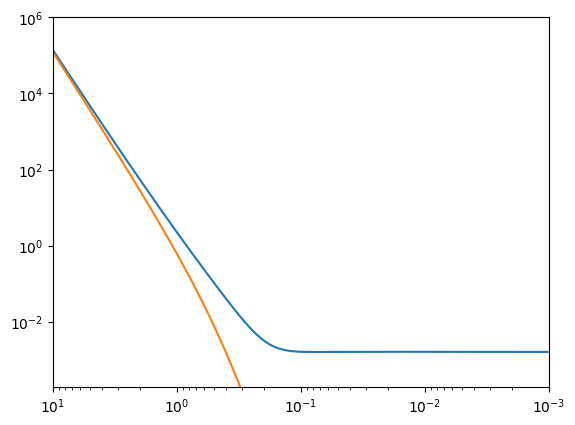

In [40]:
#plotting Neutron-proton conversion rates
import matplotlib.pyplot as plt

T=np.logspace(1,-3,1000)

fig=plt.figure()


plt.xscale('log')
plt.yscale('log')

plt.plot(T,[timeunit*lambda_n2p(T1) for T1 in T])
plt.plot(T,[timeunit*lambda_p2n(T1) for T1 in T])

plt.ylim((2e-4, 1e6))
plt.xlim((10, 1e-3))

In [41]:
#temperature conversion tests
TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K

T_ini=1 #initial temperature in MeV

t_ini=(10.4)**2/((T_ini*TMeV2T9))**2
print(t_ini)

R_dd(0.1)#(0.1)

0.8031792066848201


1.5654933591882895e-06

-3.7750917756204343


/tmp/ipykernel_424/575522332.py:29: RuntimeWarning: invalid value encountered in divide
  plt.plot(z,dB(z)/dB2)


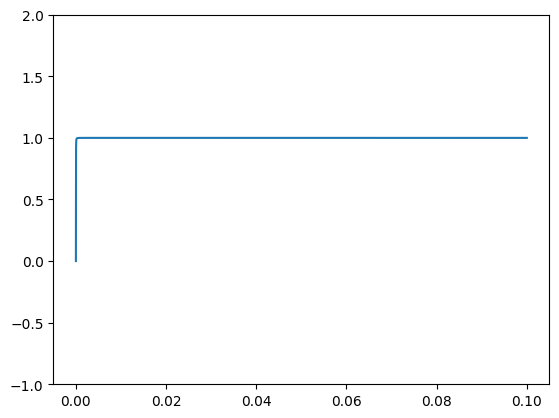

In [42]:
#test of numerical to analytical gradients


import numpy as np
from scipy import special
import matplotlib.pyplot as plt

def B(z):
    return 1/4*special.kn(1,z)/z
    return 3/4*special.kn(3,z)/z#+1/4*special.kn(1,z)/z

def dB(z):
    return -special.kn(2,z)/z/4
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z*3/4




z=np.linspace(0,0.1,10000)

dB2 = np.gradient(B(z), z)

fig2=plt.figure()

plt.ylim([-1,2])
print(dB(0.5))
#print(dB2(0.5))

plt.plot(z,dB(z)/dB2)
#plt.plot(z,dB2,'--')

0.5525810773928187


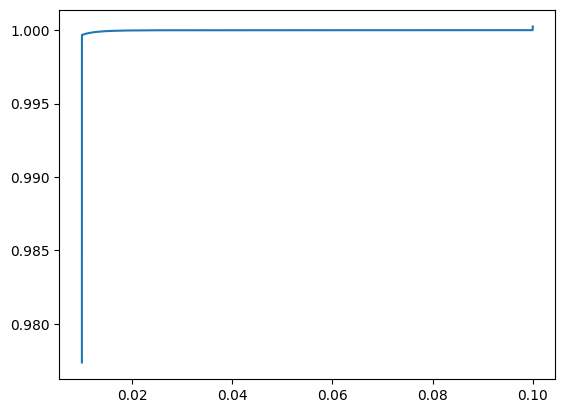

In [43]:
#test of numerical to analytical gradients

e_mass=0.51099895
def rho_e(T): #electron/positron density, phi assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: 2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)],axis=0)

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: 2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)],axis=0)



T=np.linspace(0.1,1e-2,10000)

dB2 = np.gradient(rho_e(T), T)

fig2=plt.figure()
#plt.xlim([0,2])
#plt.ylim([0,20])
print(drho_e(0.5))
#print(dB2(0.5))

#plt.plot(T,drho_e(T))
#plt.plot(T,dB2,'--')

#plt.yscale('log')
plt.plot(T,drho_e(T)/dB2)



In [44]:
#test of numerical to analytical energy density
'''
import numpy as np
from scipy import special
import matplotlib.pyplot as plt


'''
'''
e_mass=0.51099895
def rho_e(T): #electron/positron density, phi assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)],axis=0)

def rho_e2(T): #electron/positron density, phi assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))
 
    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    
    func=lambda x: 2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)],axis=0)



T=np.linspace(1,1e-2,1000)

dB2 = np.gradient(rho_e(T), T)

fig2=plt.figure()
#plt.xlim([0,2])
#plt.ylim([0,20])

print(rho_e2(0.5))
#print(dB2(0.5))

plt.plot(T,rho_e(T))
plt.plot(T,[rho_e2(T1) for T1 in T],'--')
'''


"\ne_mass=0.51099895\ndef rho_e(T): #electron/positron density, phi assumed to be 0 so cosh(phi*n)=1\n    z=e_mass/T\n    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)],axis=0)\n\ndef rho_e2(T): #electron/positron density, phi assumed to be 0 so cosh(phi*n)=1\n    z=e_mass/T\n    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))\n \n    result, error = integrate.quad(func, 0, infapprox)#[0]\n    return result\n    \n\ndef drho_e(T): #derivative of rho_e with respect to temperature\n    z=e_mass/T\n    \n    func=lambda x: 2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2))\n\n    result, error = integrate.quad(func, 0, infapprox)#[0]\n    return result\n    \n    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)],axis=0)\n\n\n\nT=np.linspace(1,1e-2,1000)\n\ndB2 = np.gradient(rho_e(T), T)\n\nfig2=plt.figure()\n#plt.xlim([0,2])\n#plt.ylim([0,20])\n\nprin

In [45]:
'''
#dum fix til at have dTdt værende afhængig af sig selv
def dTdt(t,T,h,a):
    bounds= -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h) + P_e(T)+P_gamma(T) ))

    #Varmfix  - drho_e(T)*x/3*H(T,h,a)
    eqn = lambda x: -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h) + P_e(T)+P_gamma(T)))-x
    tempsol = root_scalar(eqn, method='brentq',bracket=[bounds/2,bounds*2])
    return np.array([tempsol.root,bounds])

dTdt(1,T_ini,h_ini,1)*timeunit
'''

"\n#dum fix til at have dTdt værende afhængig af sig selv\ndef dTdt(t,T,h,a):\n    bounds= -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h) + P_e(T)+P_gamma(T) ))\n\n    #Varmfix  - drho_e(T)*x/3*H(T,h,a)\n    eqn = lambda x: -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h) + P_e(T)+P_gamma(T)))-x\n    tempsol = root_scalar(eqn, method='brentq',bracket=[bounds/2,bounds*2])\n    return np.array([tempsol.root,bounds])\n\ndTdt(1,T_ini,h_ini,1)*timeunit\n"

In [46]:
#test neutron/proton ratio
timepoint=45
print(solY.t[timepoint]/timeunit)
#
solY.y[4][timepoint]/solY.y[3][timepoint]




17.734399245306932


0.15069777109527482

In [47]:
import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

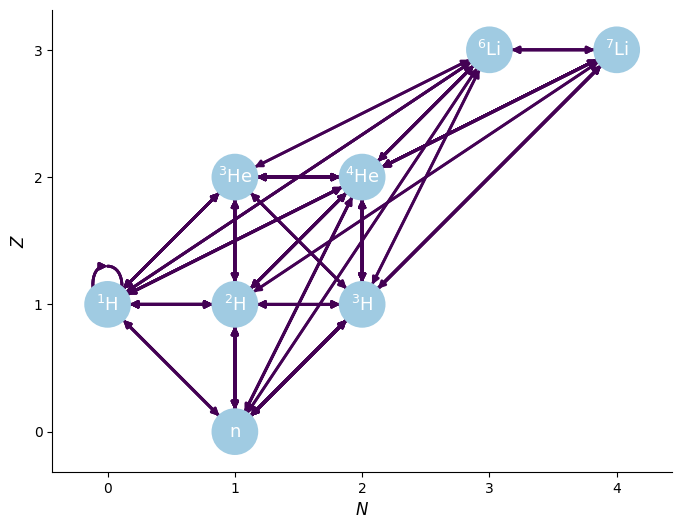

In [48]:
all_nuclei = ["p","n", "h2", "h3", "he3", "he4","Li6","Li7"]
bbn_library = reaclibrary.linking_nuclei(all_nuclei, with_reverse=True)
bbn_network = pyna.networks.PythonNetwork(libraries=bbn_library)
fig = bbn_network.plot()

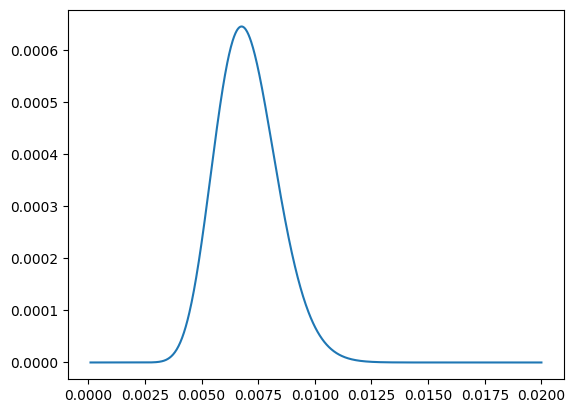

In [49]:
def testfunct(T,v):
    return s_d(m_d/2*v**2,S_dt,A_dt)*v\
    *(m_d/(2*np.pi*T))**1.5*4*np.pi*v**2*np.exp(-(m_d*v**2)/(2*T))

vspace=np.linspace(0.0001,0.02,1000)

plt.plot(vspace,[testfunct(0.01,v) for v in vspace])

In [50]:
import pynucastro as pyna


In [75]:
#Pynucastro test
reaclib_library = pyna.ReacLibLibrary()
nuclei = ["n","p", "d", "t","He3","He4","Li6","Li7","Be7"]
bbn_library = reaclib_library.linking_nuclei(nuclei)
rc = pyna.RateCollection(libraries=[bbn_library])
rc

n ⟶ p + e⁻ + 𝜈
H3 ⟶ He3 + e⁻ + 𝜈
He3 + e⁻ ⟶ H3 + 𝜈
Be7 + e⁻ ⟶ Li7 + 𝜈
H2 ⟶ n + p
H3 ⟶ n + H2
He3 ⟶ p + H2
He4 ⟶ n + He3
He4 ⟶ p + H3
He4 ⟶ H2 + H2
Li6 ⟶ He4 + H2
Li7 ⟶ n + Li6
Li7 ⟶ He4 + H3
Be7 ⟶ p + Li6
Be7 ⟶ He4 + He3
Li6 ⟶ n + p + He4
n + p ⟶ H2 + 𝛾
p + p ⟶ H2 + e⁺ + 𝜈
p + p + e⁻ ⟶ H2 + 𝜈
H2 + n ⟶ H3 + 𝛾
H2 + p ⟶ He3 + 𝛾
H2 + H2 ⟶ He4 + 𝛾
H2 + He4 ⟶ Li6 + 𝛾
H3 + p ⟶ He4 + 𝛾
H3 + He4 ⟶ Li7 + 𝛾
He3 + n ⟶ He4 + 𝛾
He3 + p ⟶ He4 + e⁺ + 𝜈
He3 + He4 ⟶ Be7 + 𝛾
Li6 + n ⟶ Li7 + 𝛾
Li6 + p ⟶ Be7 + 𝛾
H2 + H2 ⟶ n + He3
H2 + H2 ⟶ p + H3
H3 + p ⟶ n + He3
H3 + p ⟶ H2 + H2
H3 + H2 ⟶ n + He4
H3 + He4 ⟶ n + Li6
He3 + n ⟶ p + H3
He3 + n ⟶ H2 + H2
He3 + H2 ⟶ p + He4
He3 + H3 ⟶ H2 + He4
He3 + He4 ⟶ p + Li6
n + He4 ⟶ H2 + H3
p + He4 ⟶ H2 + He3
H2 + He4 ⟶ H3 + He3
He4 + He4 ⟶ n + Be7
He4 + He4 ⟶ p + Li7
Li6 + n ⟶ He4 + H3
Li6 + p ⟶ He4 + He3
Li6 + H2 ⟶ n + Be7
Li6 + H2 ⟶ p + Li7
Li7 + p ⟶ n + Be7
Li7 + p ⟶ H2 + Li6
Li7 + p ⟶ He4 + He4
Be7 + n ⟶ p + Li7
Be7 + n ⟶ H2 + Li6
Be7 + n ⟶ He4 + He4
H2 + p ⟶ n + p 

In [76]:
rc.validate(reaclib_library)

validation: missing Li7 + H2 ⟶ p + Li8 as alternative to Li7 + H2 ⟶ n + He4 + He4 (Q = -0.19103 MeV).
validation: missing Li7 + H3 ⟶ H2 + Li8 as alternative to Li7 + H3 ⟶ n + n + He4 + He4 (Q = -4.22462 MeV).
validation: missing Li7 + H3 ⟶ n + Be9 as alternative to Li7 + H3 ⟶ n + n + He4 + He4 (Q = 10.4376 MeV).


True

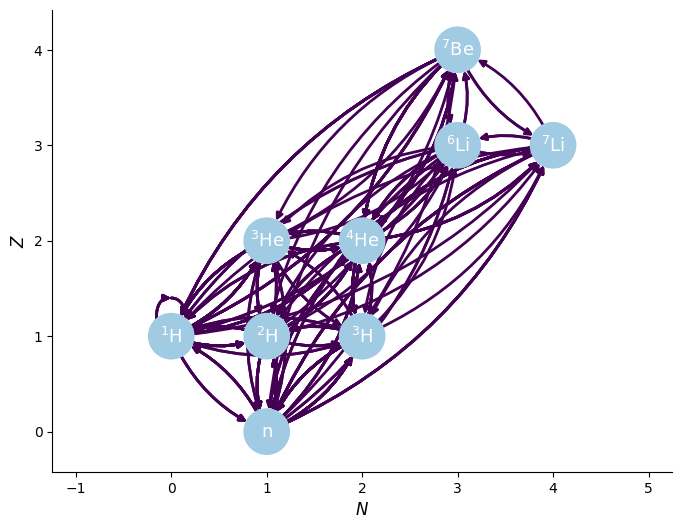

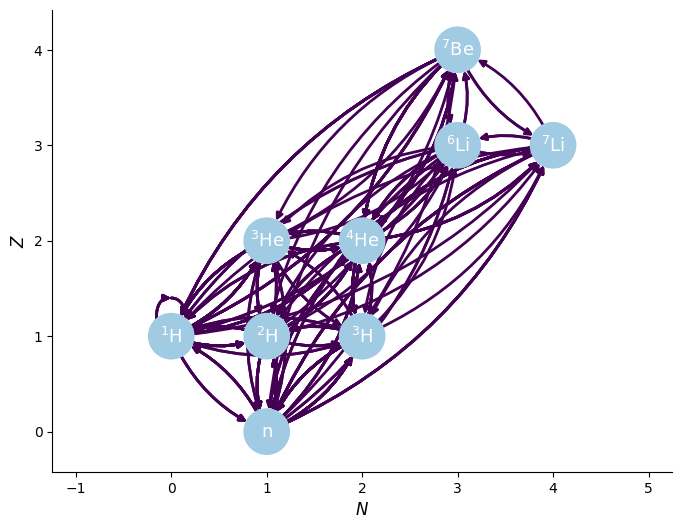

In [77]:
rc.plot(curved_edges=True)